In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def Gale_Shapley(man_preferences, woman_preferences):
    M = man_preferences.shape[0]
    W = woman_preferences.shape[0]
    man_preferences = man_preferences.tolist()
    free_man = [i for i in range(M)]

    x = np.zeros((M, W))
    
    while free_man:
        proposals = [j[0] for j in man_preferences] #man's i-th choices for proposals
        bachelors = free_man.copy()
        for man in bachelors: #for each man
            woman = proposals[man] #find desired woman
            if (x[:, woman]==1).any(): #check if woman already in relationship
                current_husband = x[:, woman].nonzero()[0][0] #find current husband
                current_woman_preferences = woman_preferences[woman]
                
                if np.where(current_woman_preferences == current_husband) < np.where(current_woman_preferences == man):
                    man_preferences[man] = man_preferences[man][1:]
                else:
                    x[current_husband, woman] = 0 #break old relationship
                    x[man, woman] = 1 #create new
                    free_man.remove(man) #remove new husband from bachelors
                    free_man.append(current_husband) #add old husband to bachelors
                    man_preferences[current_husband] = man_preferences[current_husband][1:]

                    
            else: #if she is free
                x[man, woman] = 1
                free_man.remove(man)

    return x        

In [3]:
def create_random_preference_arrays(M,W):
    men = np.arange(M)
    women = np.arange(W)
    
    men_preferences = np.tile(np.arange(W),(M,1))
    women_preferences = np.tile(np.arange(M),(W,1))
    for i in men_preferences:
        np.random.shuffle(i)
    for i in women_preferences:
        np.random.shuffle(i)
    return men_preferences, women_preferences

In [4]:
def isStable(matching, men_preferences, women_preferences):
    M,W = matching.shape
    for man,i in enumerate(matching):
        current_woman = np.where(i==1)[0][0]
        preferences = men_preferences[man]
        potential_cheaters = preferences[:np.where(preferences==current_woman)[0][0]]
        
        for cheater in potential_cheaters:
            cheater_husband = np.where(matching[:,cheater]==1)[0][0]
            if np.where(women_preferences[cheater] == man) < np.where(women_preferences[cheater] == cheater_husband):
                return False
    return True

In [5]:
def beautify_pairs(pairs):
    couples = pairs.nonzero()
    for i in range(couples[0].shape[0]):
        print(f"man :{couples[0][i]} with woman :{couples[1][i]}")

In [16]:
men_preferences, women_preferences = create_random_preference_arrays(10,10)
print('men preferences:\n',men_preferences,'\n\n women preferences:\n', women_preferences)
pairs = Gale_Shapley(men_preferences, women_preferences)
beautify_pairs(pairs)

men preferences:
 [[1 7 3 2 0 9 8 6 5 4]
 [8 3 7 4 0 9 1 6 2 5]
 [4 1 5 8 3 6 0 7 9 2]
 [5 7 6 4 0 3 9 1 8 2]
 [4 9 5 3 0 2 6 7 8 1]
 [6 4 1 5 9 7 3 0 2 8]
 [4 2 9 1 3 0 7 8 6 5]
 [3 5 2 8 4 1 0 9 6 7]
 [3 2 4 0 7 5 9 8 1 6]
 [3 5 2 1 9 0 7 4 6 8]] 

 women preferences:
 [[0 2 1 6 5 7 8 9 4 3]
 [7 0 5 2 8 1 4 6 3 9]
 [6 7 1 8 5 4 2 3 0 9]
 [5 4 9 2 7 1 0 3 6 8]
 [4 8 5 9 2 1 3 0 7 6]
 [7 8 1 9 6 5 4 0 2 3]
 [3 6 5 2 7 1 9 4 8 0]
 [0 3 1 7 8 6 5 9 4 2]
 [3 4 9 7 8 0 2 6 1 5]
 [2 1 7 3 9 8 0 4 6 5]]
man :0 with woman :1
man :1 with woman :0
man :2 with woman :8
man :3 with woman :7
man :4 with woman :4
man :5 with woman :6
man :6 with woman :2
man :7 with woman :5
man :8 with woman :9
man :9 with woman :3


In [8]:
def stability_constraints(men_preferences,women_preferences):
    M = men_preferences.shape[0]
    W = women_preferences.shape[0]
    
    #lists containing all women man 'm' prefers over woman 'w' for each man, similarly for women
    men_stability = [[men_preferences[j,np.where(men_preferences[j] == i)[0][0]:] for i in range(W) ] for j in range(M)]
    women_stability = [[women_preferences[j,np.where(women_preferences[j] == i)[0][0]:] for i in range(M) ] for j in range(W)]
    
    constraints = np.zeros((M*W,M*W)) #initialize constraints array
    for i in range(M): #for each man
        for j in range(W): #fora each woman
            x = np.zeros((M,W)) #initalize constraint row as a 2d-array
            w = women_stability[j][i] #find men, women j preferes over man i
            m = men_stability[i][j] #find women, man i prefers over woman j

            for k in w: #set each of these pairs to 1 in the constraint row
                x[k,j]=1
            for k in m:
                x[i,k]=1

            x[i,j]=1
            constraints[i*M+j,:] = x.reshape(1,-1) #reshape 2d array to 1d and add it to constraints array
            
    return constraints

In [9]:
def other_constraints(M,W):
    #monogamy constraints
    x = np.zeros((M+W,M*W)) #initialize monogamy constraints array
    row = np.pad(np.ones(W), (0,(M-1)*W)) #initialize row for men monogamy
    for i in range(M):
        x[i,:] = row #add to constraints
        row = np.roll(row,W) #shift by W to get the constraints for the next man
        
    row = np.tile(np.identity(W)[0],M) #initialize row for womenmen monogamy
    for i in range(W):
        x[M+i,:] = row
        row = np.roll(row,1) #shift by 1 to get the constraints for the next woman
    return x

In [10]:
from scipy.optimize import linprog, show_options

In [12]:
def linprog_SM(men_preferences,women_preferences):
    #get stable matching via linear programming
    M = men_preferences.shape[0]
    W = women_preferences.shape[0]
    
    #initialize constraints
    constraints1 = stability_constraints(men_preferences,women_preferences)
    constraints2 = other_constraints(M,W)
    
    #constraints rhs
    b_u = np.ones(M*W)
    b_eq = np.ones(M+W)
    
    #get optimal solution with scipy's linprog
    x = linprog(np.ones(M*W), A_ub = constraints1, b_ub = b_u, A_eq = constraints2, b_eq = b_eq, method = 'revised simplex')
#, options={'tol':1e-3, 'cholesky':False, 'presolve':False}
    return np.round(x['x'].reshape(M,W),5).astype('int') #return optimal match

In [17]:
matching2 = linprog_SM(men_preferences,women_preferences)
print('verifying stability: ', isStable(matching2, men_preferences, women_preferences))
beautify_pairs(matching2)

verifying stability:  True
man :0 with woman :1
man :1 with woman :9
man :2 with woman :0
man :3 with woman :7
man :4 with woman :4
man :5 with woman :6
man :6 with woman :2
man :7 with woman :5
man :8 with woman :8
man :9 with woman :3


<ipython-input-12-bd756f329b8b>:15: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  x = linprog(np.ones(M*W), A_ub = constraints1, b_ub = b_u, A_eq = constraints2, b_eq = b_eq, method = 'revised simplex')


In [261]:
import time

In [287]:
gale_time = []
simplex_time = []
interior_time = []
for N in range(2,30):
    print(N)
    men_preferences, women_preferences = create_random_preference_arrays(N,N)
    
    constraints1 = stability_constraints(men_preferences,women_preferences)
    constraints2 = other_constraints(N,N)
    
    b_u = np.ones(N*N)
    b_eq = np.ones(N+N)
    

    start = time.time()
    x = linprog(np.ones(N*N), A_ub = constraints1, b_ub = b_u, A_eq = constraints2, b_eq = b_eq, method = 'revised simplex')
    simplex_time.append(time.time()-start)
    
    start = time.time()
    x = linprog(np.ones(N*N), A_ub = constraints1, b_ub = b_u, A_eq = constraints2, b_eq = b_eq)
    interior_time.append(time.time()-start)
    
    start = time.time()
    matching2 = stable_marriage(men_preferences, women_preferences).astype(int)
    gale_time.append(time.time()-start)

2
3
4
5
6
7
8
9
10

<ipython-input-287-1cef82d41043>:16: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  x = linprog(np.ones(N*N), A_ub = constraints1, b_ub = b_u, A_eq = constraints2, b_eq = b_eq, method = 'revised simplex')
<ipython-input-287-1cef82d41043>:20: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  x = linprog(np.ones(N*N), A_ub = constraints1, b_ub = b_u, A_eq = constraints2, b_eq = b_eq)
<ipython-input-287-1cef82d41043>:20: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  x = linprog(np.ones(N*N), A_ub = constraints1, b_ub = b_u, A_eq = constraints2, b_eq = b_eq)
<ipython-input-287-1cef82d41043>:2


11
12
13
14


C:\Users\krist\anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=5.08417e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\Users\krist\anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=1.63675e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\Users\krist\anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=6.81195e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\Users\krist\anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=1.2999e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\Users\krist\anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=1.58477e-23): result may n

15
16


C:\Users\krist\anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=2.17183e-51): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\Users\krist\anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=1.9559e-52): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\Users\krist\anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=2.74715e-50): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\Users\krist\anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=6.48628e-51): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\Users\krist\anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=2.62927e-36): result may n

17
18
19


C:\Users\krist\anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=2.13041e-36): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\Users\krist\anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=4.90504e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\Users\krist\anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=1.30601e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\Users\krist\anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=2.07684e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\Users\krist\anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=5.9183e-35): result may n

20
21
22


C:\Users\krist\anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=1.95399e-33): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


23
24
25
26
27
28


C:\Users\krist\anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=1.12671e-49): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\Users\krist\anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=1.19407e-48): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\Users\krist\anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=6.02938e-47): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\Users\krist\anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=2.63081e-48): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\Users\krist\anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=3.70363e-49): result may 

29


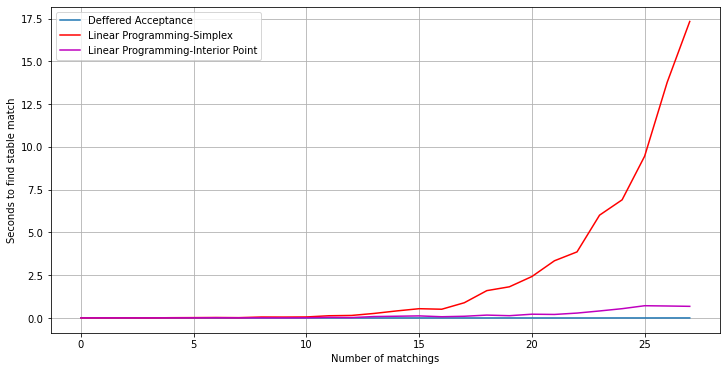

In [295]:
plt.figure(figsize=(12,6))
plt.plot(gale_time, label='Deffered Acceptance')
plt.plot(simplex_time, label='Linear Programming-Simplex', color='r')
plt.plot(interior_time, label='Linear Programming-Interior Point', color='m')
plt.xlabel('Number of matchings')
plt.ylabel('Seconds to find stable match')
plt.grid()
plt.legend()

In [296]:
gale_time = []
for N in range(2,500):
    print(N)
    for i in range(10):
        men_preferences, women_preferences = create_random_preference_arrays(N,N)
        start = time.time()
        matching2 = stable_marriage(men_preferences, women_preferences).astype(int)
        gale_time.append(time.time()-start)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

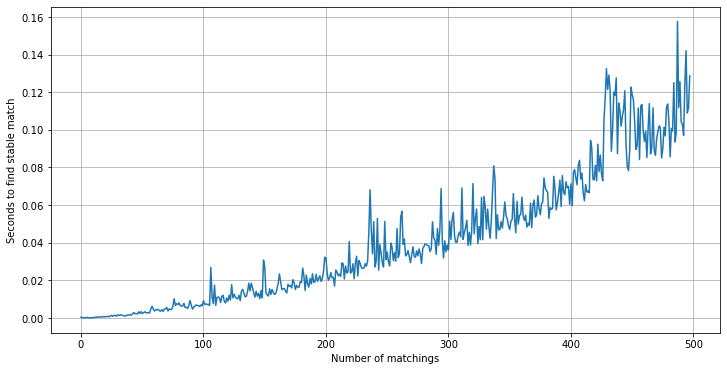

In [298]:
plt.figure(figsize=(12,6))
plt.plot(np.mean(np.array(gale_time).reshape(-1,10), axis=1))
plt.xlabel('Number of matchings')
plt.ylabel('Seconds to find stable match')
plt.grid()

In [266]:
print(matching1, 'verifying stability: ', isStable(matching1, men_preferences, women_preferences))
beautify_pairs(matching1)
print(matching2, 'verifying stability: ', isStable(matching2, men_preferences, women_preferences))
beautify_pairs(matching2)

[[0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]] verifying stability:  True
man :0 with woman :9
man :1 with woman :5
man :2 with woman :0
man :3 with woman :6
man :4 with woman :1
man :5 with woman :2
man :6 with woman :7
man :7 with woman :8
man :8 with woman :4
man :9 with woman :3
[[0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0]] verifying stability:  True
man :0 with woman :6
man :1 with woman :5
man :2 with woman :3
man :3 with woman :9
man :4 with woman :1
man :5 with woman :2
man :6 with woman :4
man :7 with woman :8
man :8 with woman :7
man :9 with woman :0


In [258]:
men_preferences, women_preferences = create_random_preference_arrays(5,5)
M = men_preferences.shape[0]
W = women_preferences.shape[0]

constraints1 = stability_constraints(men_preferences,women_preferences)
constraints2 = other_constraints(M,W)

b_u = np.ones(M*W)
b_eq = np.ones(M+W)